<a href="https://colab.research.google.com/github/ricglz/CE888_activities/blob/main/Lab_8/Transfer_learning_excercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -sL https://github.com/sagihaider/CE888_2021/raw/main/Lab_8/data.zip > data.zip
!unzip -qq data.zip

In [2]:
!mkdir data/train
!mkdir data/val
!mkdir data/test

In [3]:
base_dir = 'data'
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

In [4]:
from shutil import copyfile
from os import path, mkdir

def copy_to_dir(dst_path, category, fname):
    actual_base_dir = path.join(base_dir, category)
    dst_dir = path.join(dst_path, category)
    if not path.exists(dst_dir):
        mkdir(dst_dir)
    src = path.join(actual_base_dir, fname)
    dst = path.join(dst_dir, fname)
    copyfile(src, dst)

In [5]:
from glob import glob

def split_category(category, prefix, separator='.'):
    category_folder = path.join(base_dir, category)
    amount_in_category = len(glob(path.join(category_folder, '*.jpg')))
    train_amount = int(amount_in_category * 0.8)
    train_limit = train_amount + 1
    val_amount = (amount_in_category - train_amount) // 2
    val_limit = train_limit + val_amount
    test_limit = val_limit + val_amount
    for i in range(1, train_limit):
        copy_to_dir(train_dir, category, f'{prefix}{separator}{i}.jpg')
    for i in range(train_limit, val_limit):
        copy_to_dir(val_dir, category, f'{prefix}{separator}{i}.jpg')
    for i in range(val_limit, test_limit):
        copy_to_dir(test_dir, category, f'{prefix}{separator}{i}.jpg')

In [6]:
split_category('Humans', 'rider', '-')
split_category('cats', 'cat', '.')
split_category('dogs', 'dog', '.')
split_category('horses', 'horse', '-')

In [7]:
BATCH_SIZE = 32
DIM = 224

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data = image_dataset_from_directory(train_dir,
                                          batch_size=BATCH_SIZE,
                                          image_size=(DIM, DIM))

val_data = image_dataset_from_directory(val_dir,
                                        batch_size=BATCH_SIZE,
                                        image_size=(DIM, DIM))

test_data = image_dataset_from_directory(test_dir,
                                          batch_size=BATCH_SIZE,
                                          image_size=(DIM, DIM))

Found 644 files belonging to 4 classes.
Found 80 files belonging to 4 classes.
Found 80 files belonging to 4 classes.


In [9]:
from tensorflow.keras.layers import Input

img_input = Input(shape=(DIM, DIM, 3))

In [10]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB2

def build_general_model():
    model = EfficientNetB2(input_tensor=img_input)
    last_layer = model.get_layer('top_dropout').output
    out = Dense(4, activation='softmax', name='output')(last_layer)
    return Model(img_input, out)

In [11]:
def build_fe_model():
    model = build_general_model()
    for layer in model.layers[:-1]:
        layer.trainable = False
    return model

In [12]:
fe_model = build_fe_model()

37437440/37432240 [==============================] - 0s 0us/step


In [13]:
def build_ft_model():
    model = build_general_model()
    for layer in model.layers[:-5]:
        layer.trainable = False
    return model

In [14]:
ft_model = build_ft_model()

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def train_and_evaluate_model(model, checkpoint_path):
    my_callbacks = [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ModelCheckpoint(filepath=checkpoint_path, save_best_only=True),
    ]
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

    history = model.fit(
        train_data, epochs=10, validation_data=val_data, callbacks=my_callbacks)
    
    model.evaluate(test_data)

    return history

In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

Epoch 1/10
21/21 [==============================] - 44s 264ms/step - loss: 1.1376 - acc: 0.5217 - val_loss: 0.4583 - val_acc: 0.8625
Epoch 2/10
21/21 [==============================] - 3s 126ms/step - loss: 0.3688 - acc: 0.9357 - val_loss: 0.2643 - val_acc: 0.9375
Epoch 3/10
21/21 [==============================] - 3s 125ms/step - loss: 0.2231 - acc: 0.9482 - val_loss: 0.2011 - val_acc: 0.9750
Epoch 4/10
21/21 [==============================] - 3s 124ms/step - loss: 0.1616 - acc: 0.9707 - val_loss: 0.1681 - val_acc: 0.9750
Epoch 5/10
21/21 [==============================] - 3s 125ms/step - loss: 0.1179 - acc: 0.9896 - val_loss: 0.1468 - val_acc: 0.9750
Epoch 6/10
21/21 [==============================] - 3s 126ms/step - loss: 0.1056 - acc: 0.9769 - val_loss: 0.1315 - val_acc: 0.9750
Epoch 7/10
21/21 [==============================] - 3s 126ms/step - loss: 0.0876 - acc: 0.9922 - val_loss: 0.1230 - val_acc: 0.9750
Epoch 8/10
21/21 [==============================] - 3s 127ms/step - loss: 0

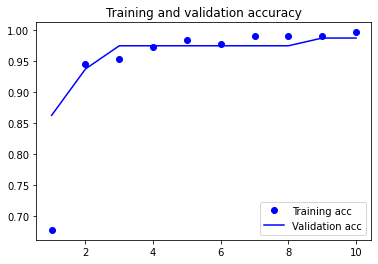

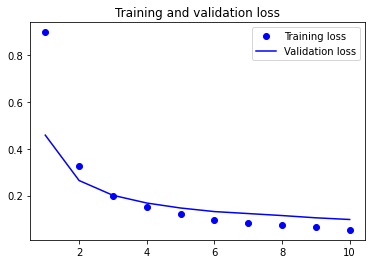

In [17]:
history = train_and_evaluate_model(fe_model, 'fe_model.h5')
plot_history(history)

Epoch 1/10
21/21 [==============================] - 11s 201ms/step - loss: 1.0403 - acc: 0.6271 - val_loss: 0.4175 - val_acc: 0.9500
Epoch 2/10
21/21 [==============================] - 3s 127ms/step - loss: 0.3599 - acc: 0.9272 - val_loss: 0.2371 - val_acc: 0.9750
Epoch 3/10
21/21 [==============================] - 3s 126ms/step - loss: 0.1902 - acc: 0.9751 - val_loss: 0.1720 - val_acc: 0.9750
Epoch 4/10
21/21 [==============================] - 3s 126ms/step - loss: 0.1635 - acc: 0.9707 - val_loss: 0.1395 - val_acc: 0.9875
Epoch 5/10
21/21 [==============================] - 3s 129ms/step - loss: 0.1339 - acc: 0.9804 - val_loss: 0.1194 - val_acc: 0.9750
Epoch 6/10
21/21 [==============================] - 3s 129ms/step - loss: 0.0947 - acc: 0.9848 - val_loss: 0.1043 - val_acc: 0.9875
Epoch 7/10
21/21 [==============================] - 3s 128ms/step - loss: 0.0909 - acc: 0.9860 - val_loss: 0.0957 - val_acc: 0.9875
Epoch 8/10
21/21 [==============================] - 3s 127ms/step - loss: 0

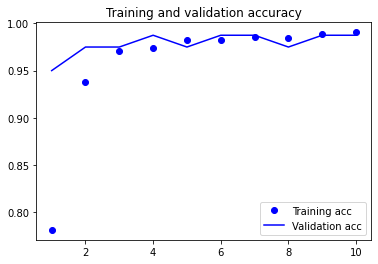

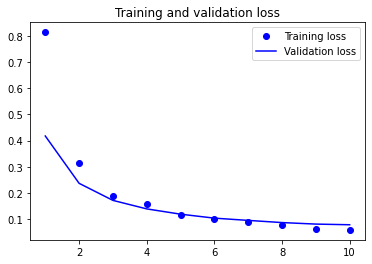

In [18]:
history = train_and_evaluate_model(ft_model, 'ft_model.h5')
plot_history(history)